Small LR (0.002): test acc=0.870, gap=-0.098, margin=-1.017, loss=0.6295
Medium LR (0.01): test acc=0.868, gap=-0.088, margin=-0.964, loss=0.6249
Large LR (0.02): test acc=0.866, gap=-0.088, margin=-0.984, loss=0.6224


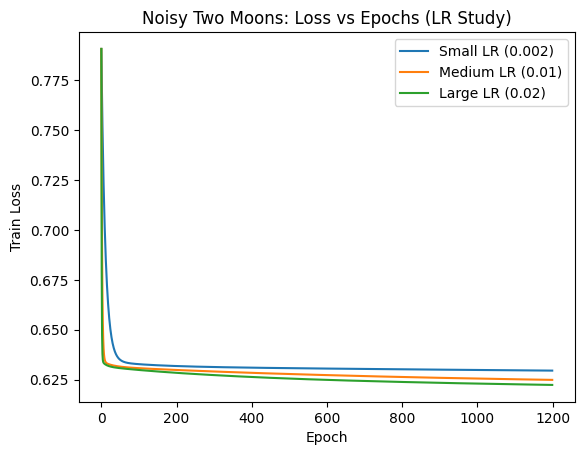

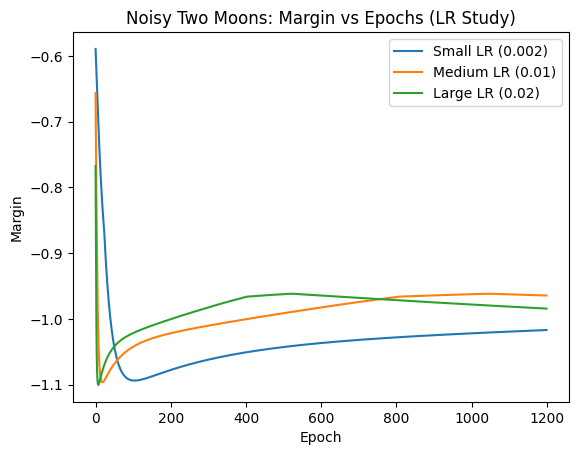

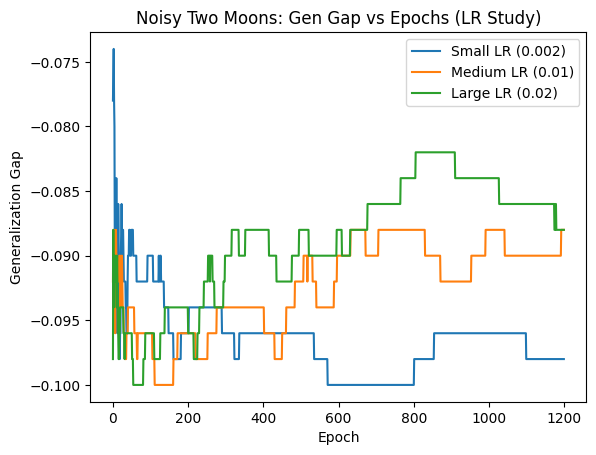

In [ ]:
import numpy as np
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def make_noisy_moons(
    n_train=500, n_test=500, noise=0.15, label_noise=0.1, seed=42
):
    X, y = make_moons(n_samples=n_train + n_test, noise=noise, random_state=seed)
    y = 2 * y - 1  # {0,1} -> {-1,+1}

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=n_test, random_state=seed, stratify=y
    )

    # Label noise ONLY on training set
    rng = np.random.default_rng(seed)
    n_flip = int(label_noise * len(y_train))
    flip_idx = rng.choice(len(y_train), size=n_flip, replace=False)
    y_train[flip_idx] *= -1

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_noisy_moons()

import torch.nn as nn

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

criterion = nn.MSELoss()

import torch.optim as optim

def train_full_batch_lr(lr, epochs=1200, seed=0):
    torch.manual_seed(seed)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    opt = optim.SGD(model.parameters(), lr=lr)

    losses, margins, train_accs, test_accs, gaps = [], [], [], [], []

    for _ in range(epochs):
        opt.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss.backward()
        opt.step()

        with torch.no_grad():
            f_tr = model(X_train)
            f_te = model(X_test)

            losses.append(loss.item())
            margins.append(torch.min(y_train * f_tr).item())

            tr_acc = (torch.sign(f_tr) == y_train).float().mean().item()
            te_acc = (torch.sign(f_te) == y_test).float().mean().item()

            train_accs.append(tr_acc)
            test_accs.append(te_acc)
            gaps.append(tr_acc - te_acc)

    return {
        "loss": losses,
        "margin": margins,
        "train_acc": train_accs,
        "test_acc": test_accs,
        "gen_gap": gaps,
        "final_test_acc": test_accs[-1],
        "final_margin": margins[-1],
        "final_gap": gaps[-1],
        "final_loss": losses[-1],
    }

epochs = 1200
learning_rates = {
    "Small LR (0.002)": 0.002,
    "Medium LR (0.01)": 0.01,
    "Large LR (0.02)": 0.02,  # stable on noisy moons
}

results = {}
for label, lr in learning_rates.items():
    res = train_full_batch_lr(lr, epochs=epochs, seed=123)
    results[label] = res
    print(f"{label}: test acc={res['final_test_acc']:.3f}, "
          f"gap={res['final_gap']:+.3f}, "
          f"margin={res['final_margin']:.3f}, "
          f"loss={res['final_loss']:.4f}")

import matplotlib.pyplot as plt

plt.figure()
for label, res in results.items():
    plt.plot(res["loss"], label=label)
plt.xlabel("Epoch"); plt.ylabel("Train Loss")
plt.title("Noisy Two Moons: Loss vs Epochs (LR Study)")
plt.legend()
plt.show()

plt.figure()
for label, res in results.items():
    plt.plot(res["margin"], label=label)
plt.xlabel("Epoch"); plt.ylabel("Margin")
plt.title("Noisy Two Moons: Margin vs Epochs (LR Study)")
plt.legend()
plt.show()

plt.figure()
for label, res in results.items():
    plt.plot(res["gen_gap"], label=label)
plt.xlabel("Epoch"); plt.ylabel("Generalization Gap")
plt.title("Noisy Two Moons: Gen Gap vs Epochs (LR Study)")
plt.legend()
plt.show()



Full batch (500): test acc=0.868, gap=-0.088, margin=-0.962, loss=0.6256
Medium batch (50): test acc=0.862, gap=-0.078, margin=-1.029, loss=0.6241
Small batch (10): test acc=0.858, gap=-0.074, margin=-1.085, loss=0.6256


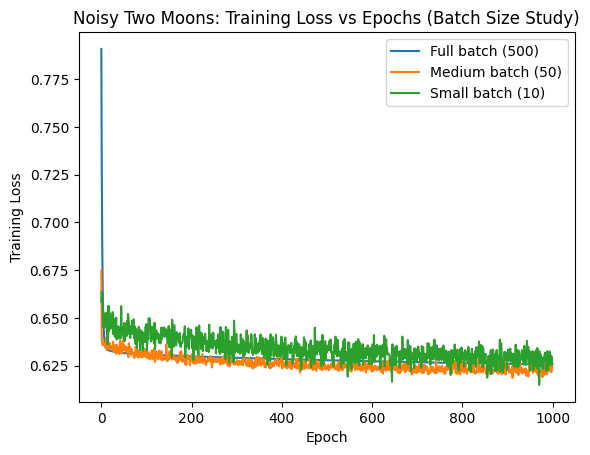

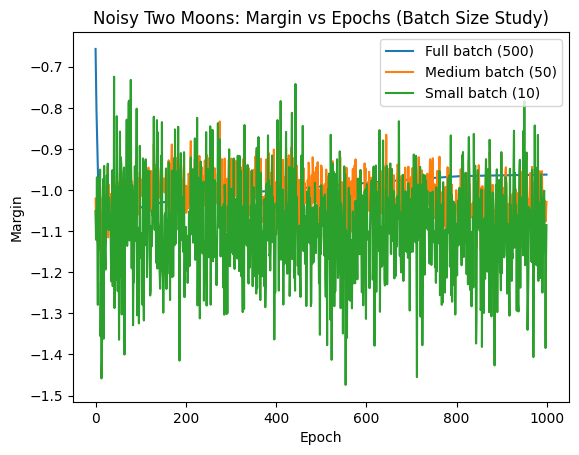

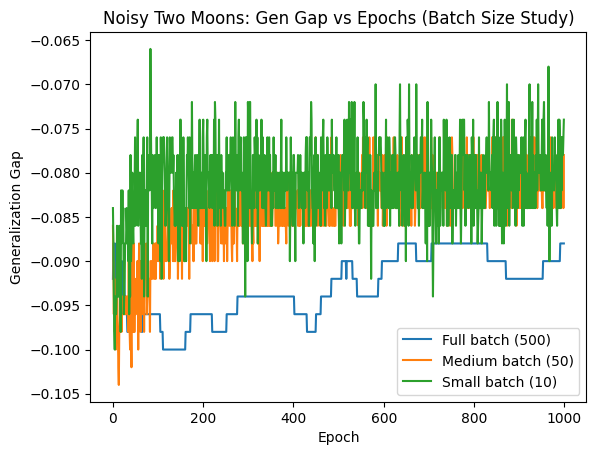

In [ ]:
import numpy as np
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def make_noisy_moons(
    n_train=500, n_test=500, noise=0.15, label_noise=0.1, seed=42
):
    X, y = make_moons(n_samples=n_train + n_test, noise=noise, random_state=seed)
    y = 2 * y - 1  # {0,1} -> {-1,+1}

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=n_test, random_state=seed, stratify=y
    )

    # Add label noise ONLY to training data
    rng = np.random.default_rng(seed)
    n_flip = int(label_noise * len(y_train))
    flip_idx = rng.choice(len(y_train), size=n_flip, replace=False)
    y_train[flip_idx] *= -1

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_noisy_moons()

import torch.nn as nn

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

criterion = nn.MSELoss()

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def train_with_batch_size(batch_size, lr=0.01, epochs=1000, seed=0):
    torch.manual_seed(seed)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    opt = optim.SGD(model.parameters(), lr=lr)

    loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )

    losses, margins, train_accs, test_accs, gaps = [], [], [], [], []

    for _ in range(epochs):
        model.train()
        total_loss = 0.0
        n = 0

        for xb, yb in loader:
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * len(xb)
            n += len(xb)

        model.eval()
        with torch.no_grad():
            f_tr = model(X_train)
            f_te = model(X_test)

            losses.append(total_loss / n)
            margins.append(torch.min(y_train * f_tr).item())

            tr_acc = (torch.sign(f_tr) == y_train).float().mean().item()
            te_acc = (torch.sign(f_te) == y_test).float().mean().item()

            train_accs.append(tr_acc)
            test_accs.append(te_acc)
            gaps.append(tr_acc - te_acc)

    return {
        "loss": losses,
        "margin": margins,
        "train_acc": train_accs,
        "test_acc": test_accs,
        "gen_gap": gaps,
        "final_test_acc": test_accs[-1],
        "final_margin": margins[-1],
        "final_gap": gaps[-1],
        "final_loss": losses[-1],
    }

epochs = 1000
lr = 0.01

batch_sizes = {
    "Full batch (500)": 500,
    "Medium batch (50)": 50,
    "Small batch (10)": 10,
}

results = {}
for label, bs in batch_sizes.items():
    res = train_with_batch_size(bs, lr=lr, epochs=epochs, seed=123)
    results[label] = res
    print(f"{label}: test acc={res['final_test_acc']:.3f}, "
          f"gap={res['final_gap']:+.3f}, "
          f"margin={res['final_margin']:.3f}, "
          f"loss={res['final_loss']:.4f}")

import matplotlib.pyplot as plt

plt.figure()
for label, res in results.items():
    plt.plot(res["loss"], label=label)
plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.title("Noisy Two Moons: Training Loss vs Epochs (Batch Size Study)")
plt.legend()
plt.show()

plt.figure()
for label, res in results.items():
    plt.plot(res["margin"], label=label)
plt.xlabel("Epoch"); plt.ylabel("Margin")
plt.title("Noisy Two Moons: Margin vs Epochs (Batch Size Study)")
plt.legend()
plt.show()

plt.figure()
for label, res in results.items():
    plt.plot(res["gen_gap"], label=label)
plt.xlabel("Epoch"); plt.ylabel("Generalization Gap")
plt.title("Noisy Two Moons: Gen Gap vs Epochs (Batch Size Study)")
plt.legend()
plt.show()



Stop Epoch	train_acc	test_acc	margin		gap		loss
100		0.782		0.868		-0.985		-0.086		0.6263
300		0.778		0.864		-1.003		-0.086		0.6215
600		0.778		0.860		-1.030		-0.082		0.6190
1000		0.784		0.862		-1.029		-0.078		0.6169


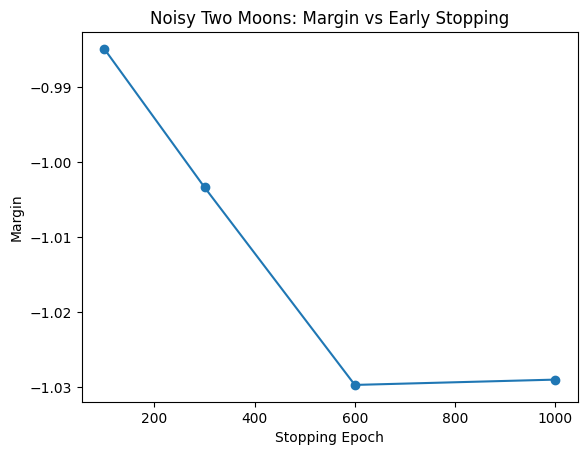

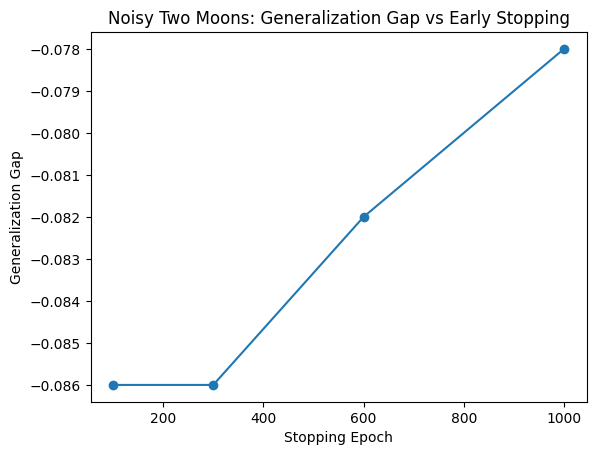

In [ ]:
#early stopping
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
def make_noisy_moons(
    n_train=500, n_test=500, noise=0.15, label_noise=0.1, seed=42
):
    X, y = make_moons(n_samples=n_train + n_test, noise=noise, random_state=seed)
    y = 2 * y - 1  # {0,1} → {-1,+1}

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=n_test, random_state=seed, stratify=y
    )

    # Add label noise ONLY to training data
    rng = np.random.default_rng(seed)
    n_flip = int(label_noise * len(y_train))
    flip_idx = rng.choice(len(y_train), size=n_flip, replace=False)
    y_train[flip_idx] *= -1

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_noisy_moons()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

criterion = nn.MSELoss()

def train_with_early_stopping(
    lr=0.01,
    batch_size=50,
    max_epochs=1000,
    stop_epochs=(100, 300, 600, 1000),
    seed=0
):
    torch.manual_seed(seed)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    opt = optim.SGD(model.parameters(), lr=lr)

    loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )

    history = {}

    for epoch in range(1, max_epochs + 1):
        model.train()
        for xb, yb in loader:
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()

        # Record metrics at stopping points
        if epoch in stop_epochs:
            model.eval()
            with torch.no_grad():
                f_tr = model(X_train)
                f_te = model(X_test)

                train_acc = (torch.sign(f_tr) == y_train).float().mean().item()
                test_acc  = (torch.sign(f_te) == y_test).float().mean().item()
                margin    = torch.min(y_train * f_tr).item()
                gap       = train_acc - test_acc
                final_loss = criterion(f_tr, y_train).item()

            history[epoch] = {
                "train_acc": train_acc,
                "test_acc": test_acc,
                "margin": margin,
                "gen_gap": gap,
                "loss": final_loss,
            }

    return history

stop_epochs = [100, 300, 600, 1000]

results = train_with_early_stopping(
    lr=0.01,
    batch_size=50,
    max_epochs=1000,
    stop_epochs=stop_epochs,
    seed=123
)

print("Stop Epoch\ttrain_acc\ttest_acc\tmargin\t\tgap\t\tloss")
for e in stop_epochs:
    r = results[e]
    print(
        f"{e}\t\t"
        f"{r['train_acc']:.3f}\t\t"
        f"{r['test_acc']:.3f}\t\t"
        f"{r['margin']:.3f}\t\t"
        f"{r['gen_gap']:+.3f}\t\t"
        f"{r['loss']:.4f}"
    )

epochs = list(results.keys())
margins = [results[e]["margin"] for e in epochs]

plt.figure()
plt.plot(epochs, margins, marker="o")
plt.xlabel("Stopping Epoch")
plt.ylabel("Margin")
plt.title("Noisy Two Moons: Margin vs Early Stopping")
plt.show()

gaps = [results[e]["gen_gap"] for e in epochs]

plt.figure()
plt.plot(epochs, gaps, marker="o")
plt.xlabel("Stopping Epoch")
plt.ylabel("Generalization Gap")
plt.title("Noisy Two Moons: Generalization Gap vs Early Stopping")
plt.show()


In [ ]:
#flatness prixy for learning rate

import numpy as np
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def make_noisy_moons(
    n_train=500, n_test=500, noise=0.15, label_noise=0.1, seed=42
):
    X, y = make_moons(n_samples=n_train + n_test, noise=noise, random_state=seed)
    y = 2 * y - 1  # {0,1} -> {-1,+1}

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=n_test, random_state=seed, stratify=y
    )

    # label noise only on training data
    rng = np.random.default_rng(seed)
    n_flip = int(label_noise * len(y_train))
    flip_idx = rng.choice(len(y_train), size=n_flip, replace=False)
    y_train[flip_idx] *= -1

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_noisy_moons()

import torch.nn as nn

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

criterion = nn.MSELoss()

import torch.optim as optim

def train_full_batch_lr(lr, epochs=1200, seed=0):
    torch.manual_seed(seed)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    opt = optim.SGD(model.parameters(), lr=lr)

    losses, margins, train_accs, test_accs, gaps = [], [], [], [], []

    for _ in range(epochs):
        opt.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss.backward()
        opt.step()

        with torch.no_grad():
            f_tr = model(X_train)
            f_te = model(X_test)

            losses.append(loss.item())
            margins.append(torch.min(y_train * f_tr).item())

            tr_acc = (torch.sign(f_tr) == y_train).float().mean().item()
            te_acc = (torch.sign(f_te) == y_test).float().mean().item()

            train_accs.append(tr_acc)
            test_accs.append(te_acc)
            gaps.append(tr_acc - te_acc)

    return model, {
        "loss": losses,
        "margin": margins,
        "train_acc": train_accs,
        "test_acc": test_accs,
        "gen_gap": gaps,
        "final_test_acc": test_accs[-1],
        "final_margin": margins[-1],
        "final_gap": gaps[-1],
        "final_loss": losses[-1],
    }

def flatness_proxy(model, X, y, criterion, sigma=1e-3, num_samples=20):
    model.eval()
    base_loss = criterion(model(X), y).item()

    params = [p for p in model.parameters() if p.requires_grad]
    flatness_vals = []

    for _ in range(num_samples):
        noise = []
        for p in params:
            eps = torch.randn_like(p) * sigma
            noise.append(eps)
            p.data.add_(eps)

        noisy_loss = criterion(model(X), y).item()
        flatness_vals.append(noisy_loss - base_loss)

        # restore parameters
        for p, eps in zip(params, noise):
            p.data.sub_(eps)

    return float(np.mean(flatness_vals))

epochs = 1200
learning_rates = {
    "Small LR (0.002)": 0.002,
    "Medium LR (0.01)": 0.01,
    "Large LR (0.02)": 0.02,
}

print("LR\t\ttrain_acc\ttest_acc\tmargin\t\tflatness")

results = {}

for label, lr in learning_rates.items():
    model, res = train_full_batch_lr(lr, epochs=epochs, seed=123)

    flat = flatness_proxy(
        model,
        X_train,
        y_train,
        criterion,
        sigma=1e-3,
        num_samples=20
    )

    results[label] = {**res, "flatness": flat}

    print(
        f"{lr:.3g}\t\t"
        f"{res['train_acc'][-1]:.3f}\t\t"
        f"{res['final_test_acc']:.3f}\t\t"
        f"{res['final_margin']:.4f}\t\t"
        f"{flat:.4e}"
    )




LR		train_acc	test_acc	margin		flatness
0.002		0.772		0.870		-1.0170		2.8670e-05
0.01		0.780		0.868		-0.9645		3.4407e-05
0.02		0.778		0.866		-0.9844		3.8975e-05


Batch		train_acc	test_acc	margin		flatness
Full batch (500)	0.780		0.868		-0.962		3.3375e-05
Medium batch (50)	0.784		0.862		-1.029		8.3810e-05
Small batch (10)	0.784		0.858		-1.085		1.9906e-04


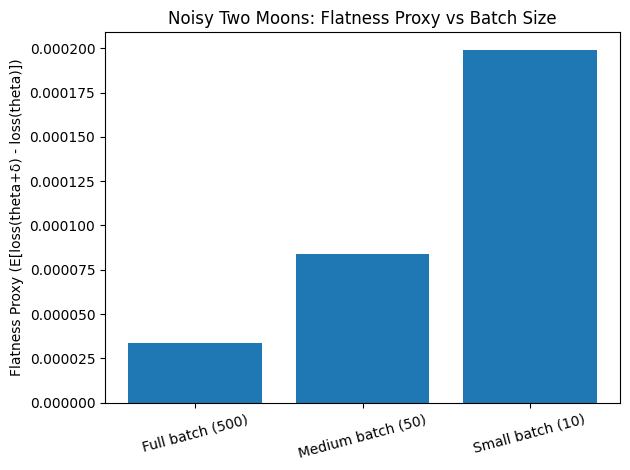

In [ ]:
#flatteness proxy for batch size
import numpy as np
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def make_noisy_moons(
    n_train=500, n_test=500, noise=0.15, label_noise=0.1, seed=42
):
    X, y = make_moons(n_samples=n_train + n_test, noise=noise, random_state=seed)
    y = 2 * y - 1  # {0,1} -> {-1,+1}

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=n_test, random_state=seed, stratify=y
    )

    # Add label noise ONLY to training data
    rng = np.random.default_rng(seed)
    n_flip = int(label_noise * len(y_train))
    flip_idx = rng.choice(len(y_train), size=n_flip, replace=False)
    y_train[flip_idx] *= -1

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_noisy_moons()

import torch.nn as nn

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

criterion = nn.MSELoss()

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def train_with_batch_size(batch_size, lr=0.01, epochs=1000, seed=0):
    torch.manual_seed(seed)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    opt = optim.SGD(model.parameters(), lr=lr)

    loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )

    losses, margins, train_accs, test_accs, gaps = [], [], [], [], []

    for _ in range(epochs):
        model.train()
        total_loss = 0.0
        n = 0

        for xb, yb in loader:
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * len(xb)
            n += len(xb)

        model.eval()
        with torch.no_grad():
            f_tr = model(X_train)
            f_te = model(X_test)

            losses.append(total_loss / n)
            margins.append(torch.min(y_train * f_tr).item())

            tr_acc = (torch.sign(f_tr) == y_train).float().mean().item()
            te_acc = (torch.sign(f_te) == y_test).float().mean().item()

            train_accs.append(tr_acc)
            test_accs.append(te_acc)
            gaps.append(tr_acc - te_acc)

    return {
        "loss": losses,
        "margin": margins,
        "train_acc": train_accs,
        "test_acc": test_accs,
        "gen_gap": gaps,
        "final_test_acc": test_accs[-1],
        "final_margin": margins[-1],
        "final_gap": gaps[-1],
        "final_loss": losses[-1],
    }

epochs = 1000
lr = 0.01

batch_sizes = {
    "Full batch (500)": 500,
    "Medium batch (50)": 50,
    "Small batch (10)": 10,
}

import numpy as np
import torch

def flatness_proxy(model, X, y, criterion, sigma=1e-3, num_samples=20):
    model.eval()
    with torch.no_grad():
        base_loss = criterion(model(X), y).item()

    params = [p for p in model.parameters() if p.requires_grad]
    flatness_vals = []

    for _ in range(num_samples):
        noise = []
        for p in params:
            eps = torch.randn_like(p) * sigma
            noise.append(eps)
            p.data.add_(eps)

        with torch.no_grad():
            noisy_loss = criterion(model(X), y).item()
        flatness_vals.append(noisy_loss - base_loss)

        # restore
        for p, eps in zip(params, noise):
            p.data.sub_(eps)

    return float(np.mean(flatness_vals))

def train_with_batch_size(batch_size, lr=0.01, epochs=1000, seed=0):
    torch.manual_seed(seed)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    opt = optim.SGD(model.parameters(), lr=lr)

    loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )

    losses, margins, train_accs, test_accs, gaps = [], [], [], [], []

    for _ in range(epochs):
        model.train()
        total_loss = 0.0
        n = 0

        for xb, yb in loader:
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * len(xb)
            n += len(xb)

        model.eval()
        with torch.no_grad():
            f_tr = model(X_train)
            f_te = model(X_test)

            losses.append(total_loss / n)
            margins.append(torch.min(y_train * f_tr).item())

            tr_acc = (torch.sign(f_tr) == y_train).float().mean().item()
            te_acc = (torch.sign(f_te) == y_test).float().mean().item()

            train_accs.append(tr_acc)
            test_accs.append(te_acc)
            gaps.append(tr_acc - te_acc)

    res = {
        "loss": losses,
        "margin": margins,
        "train_acc": train_accs,
        "test_acc": test_accs,
        "gen_gap": gaps,
        "final_test_acc": test_accs[-1],
        "final_margin": margins[-1],
        "final_gap": gaps[-1],
        "final_loss": losses[-1],
    }

    return model, res

print("Batch\t\ttrain_acc\ttest_acc\tmargin\t\tflatness")

results = {}

for label, bs in batch_sizes.items():
    model, res = train_with_batch_size(bs, lr=lr, epochs=epochs, seed=123)

    flat = flatness_proxy(
        model, X_train, y_train, criterion,
        sigma=1e-3, num_samples=30
    )

    res["flatness"] = flat
    results[label] = res

    print(
        f"{label:16s}\t"
        f"{res['train_acc'][-1]:.3f}\t\t"
        f"{res['final_test_acc']:.3f}\t\t"
        f"{res['final_margin']:.3f}\t\t"
        f"{flat:.4e}"
    )
import matplotlib.pyplot as plt

labels = list(results.keys())
flat_vals = [results[k]["flatness"] for k in labels]

plt.figure()
plt.bar(labels, flat_vals)
plt.ylabel("Flatness Proxy (E[loss(theta+δ) - loss(theta)])")
plt.title("Noisy Two Moons: Flatness Proxy vs Batch Size")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Stop Epoch	train_acc	test_acc	margin		gap		flatness
100		0.782		0.868		-0.985		-0.086		7.8195e-05
300		0.778		0.864		-1.025		-0.086		-4.2220e-06
600		0.782		0.862		-1.086		-0.080		8.2672e-05
1000		0.778		0.860		-1.031		-0.082		7.1847e-05


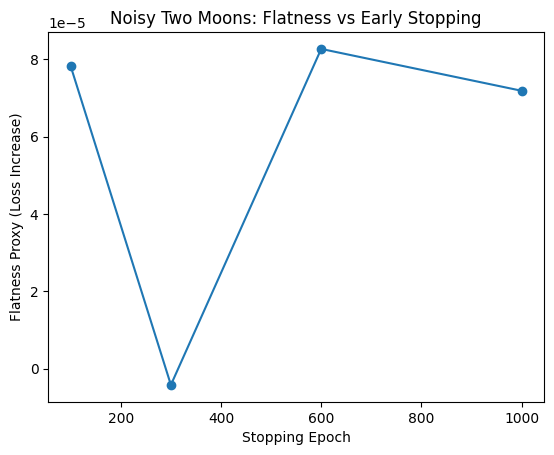

In [ ]:
#flatness proxy for early stopping
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def make_noisy_moons(
    n_train=500, n_test=500, noise=0.15, label_noise=0.1, seed=42
):
    X, y = make_moons(n_samples=n_train + n_test, noise=noise, random_state=seed)
    y = 2 * y - 1  # {0,1} → {-1,+1}

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=n_test, random_state=seed, stratify=y
    )

    rng = np.random.default_rng(seed)
    n_flip = int(label_noise * len(y_train))
    flip_idx = rng.choice(len(y_train), size=n_flip, replace=False)
    y_train[flip_idx] *= -1

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_noisy_moons()
class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

criterion = nn.MSELoss()
def flatness_proxy(model, X, y, criterion, sigma=1e-3, num_samples=30):
    model.eval()
    with torch.no_grad():
        base_loss = criterion(model(X), y).item()

    params = [p for p in model.parameters() if p.requires_grad]
    flatness_vals = []

    for _ in range(num_samples):
        noise = []
        for p in params:
            eps = torch.randn_like(p) * sigma
            noise.append(eps)
            p.data.add_(eps)

        with torch.no_grad():
            noisy_loss = criterion(model(X), y).item()
        flatness_vals.append(noisy_loss - base_loss)

        for p, eps in zip(params, noise):
            p.data.sub_(eps)

    return float(np.mean(flatness_vals))
def train_with_early_stopping_and_flatness(
    lr=0.01,
    batch_size=50,
    max_epochs=1000,
    stop_epochs=(100, 300, 600, 1000),
    seed=0,
    sigma=1e-3
):
    torch.manual_seed(seed)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    opt = optim.SGD(model.parameters(), lr=lr)

    loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )

    history = {}

    for epoch in range(1, max_epochs + 1):
        model.train()
        for xb, yb in loader:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()

        if epoch in stop_epochs:
            model.eval()
            with torch.no_grad():
                f_tr = model(X_train)
                f_te = model(X_test)

                train_acc = (torch.sign(f_tr) == y_train).float().mean().item()
                test_acc  = (torch.sign(f_te) == y_test).float().mean().item()
                margin    = torch.min(y_train * f_tr).item()
                gap       = train_acc - test_acc
                final_loss = criterion(f_tr, y_train).item()

            flat = flatness_proxy(
                model, X_train, y_train, criterion,
                sigma=sigma, num_samples=30
            )

            history[epoch] = {
                "train_acc": train_acc,
                "test_acc": test_acc,
                "margin": margin,
                "gen_gap": gap,
                "loss": final_loss,
                "flatness": flat,
            }

    return history
stop_epochs = [100, 300, 600, 1000]

results = train_with_early_stopping_and_flatness(
    lr=0.01,
    batch_size=50,
    max_epochs=1000,
    stop_epochs=stop_epochs,
    seed=123
)

print("Stop Epoch\ttrain_acc\ttest_acc\tmargin\t\tgap\t\tflatness")
for e in stop_epochs:
    r = results[e]
    print(
        f"{e}\t\t"
        f"{r['train_acc']:.3f}\t\t"
        f"{r['test_acc']:.3f}\t\t"
        f"{r['margin']:.3f}\t\t"
        f"{r['gen_gap']:+.3f}\t\t"
        f"{r['flatness']:.4e}"
    )
epochs = list(results.keys())
flat_vals = [results[e]["flatness"] for e in epochs]

plt.figure()
plt.plot(epochs, flat_vals, marker="o")
plt.xlabel("Stopping Epoch")
plt.ylabel("Flatness Proxy (Loss Increase)")
plt.title("Noisy Two Moons: Flatness vs Early Stopping")
plt.show()
